In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn import linear_model
from math import *
from util import *

plt.rcParams["figure.figsize"] = (16, 9)

In [2]:
# parseo con fechas
df = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv', parse_dates=[0])
# rename de columnas
df.columns = ['dt', 'avg', 'error', 'country']
# toordinal() para tener una fecha numerica monotona
df['ordinal'] = df['dt'].apply(lambda d: d.toordinal())
# arreglo nombres
df['country'] = df['country'].apply(lambda d: d.replace('_', ' '))
# agrego year
df['year'] = df['dt'].apply(lambda d: d.year)
# filtro los NaN
df = df[df.avg.notnull()]

In [3]:
d1960 = datetime(1960, 1, 1)
d1990 = datetime(1990, 1, 1)
data1960_1990 = df[(d1960 < df['dt']) & (df['dt']< d1990)].groupby('country', as_index=False)['avg'].mean()
data1960_1990.head()

,country,avg
0,Afghanistan,14.230730
1,Africa,24.254075
2,Albania,12.792914
3,Algeria,23.256357
4,American Samoa,26.772630


# Media histórica

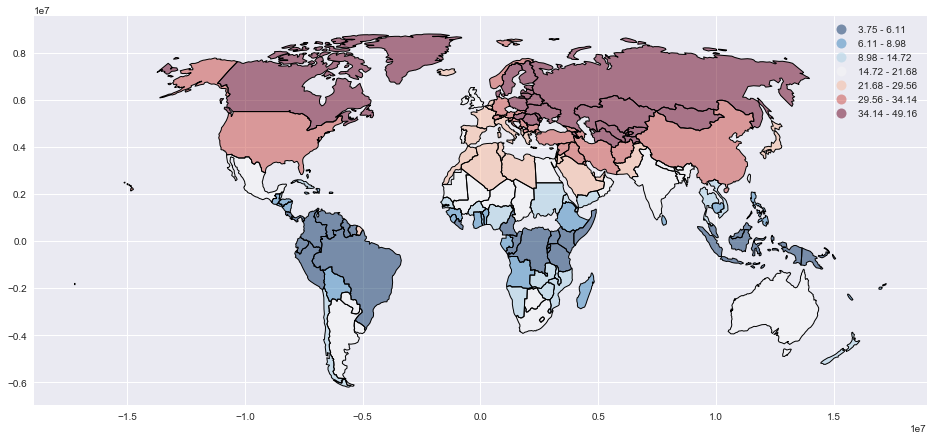

In [4]:
means = df.groupby('country', as_index=False)["avg"].aggregate(["min", "max"])
means["amplitude"] = means["max"] - means["min"]
#means.to_csv('means.csv')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# fixing names
world.loc[33, "name"] = "Congo (Democratic Republic Of The)"

# joining
world = world.set_index('name')
join = world.join(means, how='inner').to_crs('+proj=natearth')
join.plot(column='amplitude', cmap='RdBu_r', scheme='quantiles', k=7, legend=True)
#plt.savefig('img/amplitude_map.png', dpi=300, bbox_inches='tight')

err hasta 1920 = 0.7367636343417249


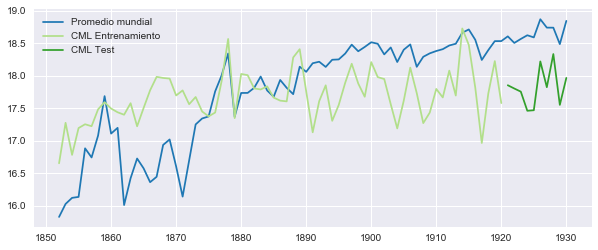

In [36]:
plt.rcParams["figure.figsize"] = (10, 4)
palette = sns.color_palette('Paired', 12)
countries = ['Canada', 'Brazil', 'United Kingdom', 'Australia']

cf = df[df['country'].isin(countries)].copy()
cf['year'] = cf['dt'].apply(lambda d: d.year)
min_year = cf.groupby('country')['year'].min().max()
cf = cf[cf['year'] >= min_year]
cf = cf.groupby(['year', 'country'], as_index=False).mean()
cf = cf[['year', 'country', 'avg']]

world_df = df.groupby(['year'], as_index=False).mean().query('year >= @min_year').copy()
world_df.index = world_df['year']


cf = cf.pivot(index='year', columns='country', values='avg')
cf['world'] = world_df['avg']


errs = []
for y in range(1860, 2010):
    cf_tr = cf.query('year <= @y')
    until = y + 10
    cf_tt = cf.query('year > @y').query('year <= @until')

    f = cml(lambda x: [1, x[0], x[1], x[2], x[3]],
            cf_tr.as_matrix(),
            cf_tr['world'])

    results_tr = list(map(f, cf_tr.as_matrix()))
    results_tt = list(map(f, cf_tt.as_matrix()))
    
    err = ecm(results_tt, cf_tt['world'])
    errs.append(err)
    
    if y == 1920:
        cf_world = cf.query('year <= @until')
        print('err hasta {} = {}'.format(y, err))
        plt.plot(cf_world.index, cf_world['world'], 'r', color=palette[1], label='Promedio mundial')
        plt.plot(cf_tr.index, results_tr, 'r', color=palette[2], label='CML Entrenamiento')
        plt.plot(cf_tt.index, results_tt, 'r', color=palette[3], label='CML Test')
        plt.legend()
        #plt.savefig('img/country_corte.png', dpi=200)
        plt.show()

Total: 150
0.493460197844 2.98664763396 0.0413249897229


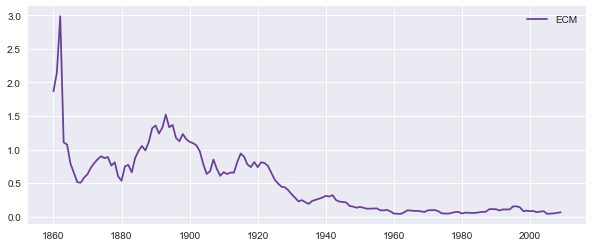

In [39]:
print('Total:', len(errs))
plt.plot(range(1860, 2010), errs, label='ECM', color=palette[9])
plt.legend()
#plt.savefig('img/country_ecm.png', dpi=200)

print(sum(errs)/len(errs), max(errs), min(errs))